In [1]:
import deepSI
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy.io import loadmat

## Set test, validation and training ids

There are 21 data sets and they are divided as follows

In [2]:
minus1 = lambda x: [xi-1 for xi in x] # utility functions to convert from and to 1 indexing
plus1  = lambda x: [xi+1 for xi in x]

remove_ids = minus1([21]) #remove data set 21 it is unlike the other data sets.
test_ids   = minus1([5,13,14,17])
val_ids    = minus1([2,6,19])
train_ids = [i for i in range(21) if (i not in test_ids) and (i not in remove_ids) and (i not in val_ids)]

print('test:',plus1(test_ids),'val:',plus1(val_ids),'train:',plus1(train_ids))

test: [5, 13, 14, 17] val: [2, 6, 19] train: [1, 3, 4, 7, 8, 9, 10, 11, 12, 15, 16, 18, 20]


## Load nissan leaf

In [3]:
def get_data(full=False, sub1=False, sub2=False,downsample=None,downsample_factor=1,split_data=True,include_throttle=False):
    '''Load the nissan leaf data
    
    Parameters
    ----------
    full : Boole
        Model the full system (both moduals) (Uvoltage, GPSvel -> yawrate)
    sub1 : Boole
        Model the first module of the controller (Uvoltage, yawrate, GPSvel -> delta)
    sub2 : Boole
        Model the second module of the yaw rate (delta, GPSvel -> yawrate)
      
    downsample : None or string
        None -> no downsampling
        'decimate' -> use scipy.signal.decimate
        'MIMO' -> restructure data as u.shape = (N/factor, nu*factor), y.shape = (N/factor)
    downsample_factor : int
    split_data : Boole
    include_throttle : Boole
    
    Returns
    -------
    (train, test, val) or full : deepSI.System_data_list
    '''
    D = loadmat('./Data-nissan-leaf/NissanSteeringExperiments_2020.mat')['D']
    train_data = []
    test_data = []
    val_data = []
    assert np.any([full,sub1,sub2]), 'select which part you want to model'
    for i in range(D.shape[1]):
        fileidx,segmidx,time,deltaref,vref,Uvoltage,directVoltage,XY,Yaw,GPSvel,CANvel,delta,yawrate,ax,ay,throttle,brake = D[0,i]
        
        if full:
            #Uvoltage, GPSvel -> yawrate
            #possibly to include CANvel and throttle
            if include_throttle:
                u = np.concatenate([Uvoltage,GPSvel,throttle],axis=1)
            else:
                u = np.concatenate([Uvoltage,GPSvel],axis=1)
            y = yawrate[:,0]
            
        elif sub1:
            #Uvoltage, yawrate, GPSvel -> delta
            u = np.concatenate([Uvoltage,yawrate,GPSvel],axis=1)
            y = delta[:,0]
            
        elif sub2:
            #delta, GPSvel -> yawrate
            u = np.concatenate([delta,GPSvel],axis=1)
            y = yawrate[:,0]
            
        
        sys_data = deepSI.System_data(u=u,y=y)
        if np.any(np.isnan(sys_data.y)) or np.any(np.isnan(sys_data.u)):
            sys_data.u,sys_data.y = sys_data.u[:-1],sys_data.y[:-1]

        #place downsampling here
        if downsample=='decimate':
            sys_data = sys_data.down_sample_by_decimate(downsample_factor)
        elif downsample=='MIMO':
            sys_data = sys_data.down_sample_by_MIMO(downsample_factor)
        
        if not split_data:
            train_data.append(sys_data)
        elif i in train_ids:
            train_data.append(sys_data)
        elif i in val_ids:
            val_data.append(sys_data)
        elif i in test_ids:
            test_data.append(sys_data)
    
    if not split_data:
        return deepSI.System_data_list(train_data)
    else:
        return (deepSI.System_data_list(train_data), deepSI.System_data_list(test_data), deepSI.System_data_list(val_data))


In [4]:
train, test, val = get_data(full=True,downsample='decimate',downsample_factor=10,include_throttle=False,split_data=True)
full             = get_data(full=True,downsample='decimate',downsample_factor=10,include_throttle=False,split_data=False)

In [5]:
if False: #set true if you want to fit the data
    sys_encoder = deepSI.fit_systems.System_encoder(nx=40,na=40,nb=40)
    sys_encoder.fit(train,epochs=2500,Loss_kwargs=dict(nf=100),batch_size=512,sim_val=val)
    sys_encoder.save_system('./SS-encoder-model-final-result') #watch out for overwrite of the original
else:
    sys_encoder = deepSI.load_system('./SS-encoder-model-final-result')

## Analysis

### Apply system on all of the data

In [6]:
full_sim = sys_encoder.apply_experiment(full)

### NRMS results

In [7]:
def get_string(i):
    if (i in train_ids):
        s = 'train'
    elif (i in val_ids):
        s = 'val'
    elif (i in test_ids):
        s = '##test##'
    else:
        s = 'removed'
    return s
        
def print_test(full, full_sim):
    print('Results in matlab 1 indexing')
    print('### Test Results ###')
    R = []
    for i in test_ids:
        s = get_string(i)
        R.append(full_sim[i].NRMS(full[i]))
        print(f'i={i+1} {s} = {R[-1]:.2%} NRMS ')
    print(f'MEAN test set results: {np.mean(R):.2%}')

def print_all(full, full_sim):
    print('\n### Full Results ###')
    for i in range(len(full_sim)):
        print(f'i={i+1} {get_string(i)} = {full_sim[i].NRMS(full[i]):.2%} NRMS ')

print_test(full,full_sim)
print_all(full,full_sim)

Results in matlab 1 indexing
### Test Results ###
i=5 ##test## = 20.48% NRMS 
i=13 ##test## = 25.79% NRMS 
i=14 ##test## = 17.33% NRMS 
i=17 ##test## = 20.86% NRMS 
MEAN test set results: 21.12%

### Full Results ###
i=1 train = 62.79% NRMS 
i=2 val = 19.85% NRMS 
i=3 train = 13.03% NRMS 
i=4 train = 16.85% NRMS 
i=5 ##test## = 20.48% NRMS 
i=6 val = 20.44% NRMS 
i=7 train = 26.71% NRMS 
i=8 train = 21.54% NRMS 
i=9 train = 35.48% NRMS 
i=10 train = 17.80% NRMS 
i=11 train = 18.02% NRMS 
i=12 train = 16.16% NRMS 
i=13 ##test## = 25.79% NRMS 
i=14 ##test## = 17.33% NRMS 
i=15 train = 12.87% NRMS 
i=16 train = 12.15% NRMS 
i=17 ##test## = 20.86% NRMS 
i=18 train = 15.63% NRMS 
i=19 val = 20.10% NRMS 
i=20 train = 25.64% NRMS 
i=21 removed = 45.69% NRMS 


### Figures of overlayed and residuals

######## Overlayed #########


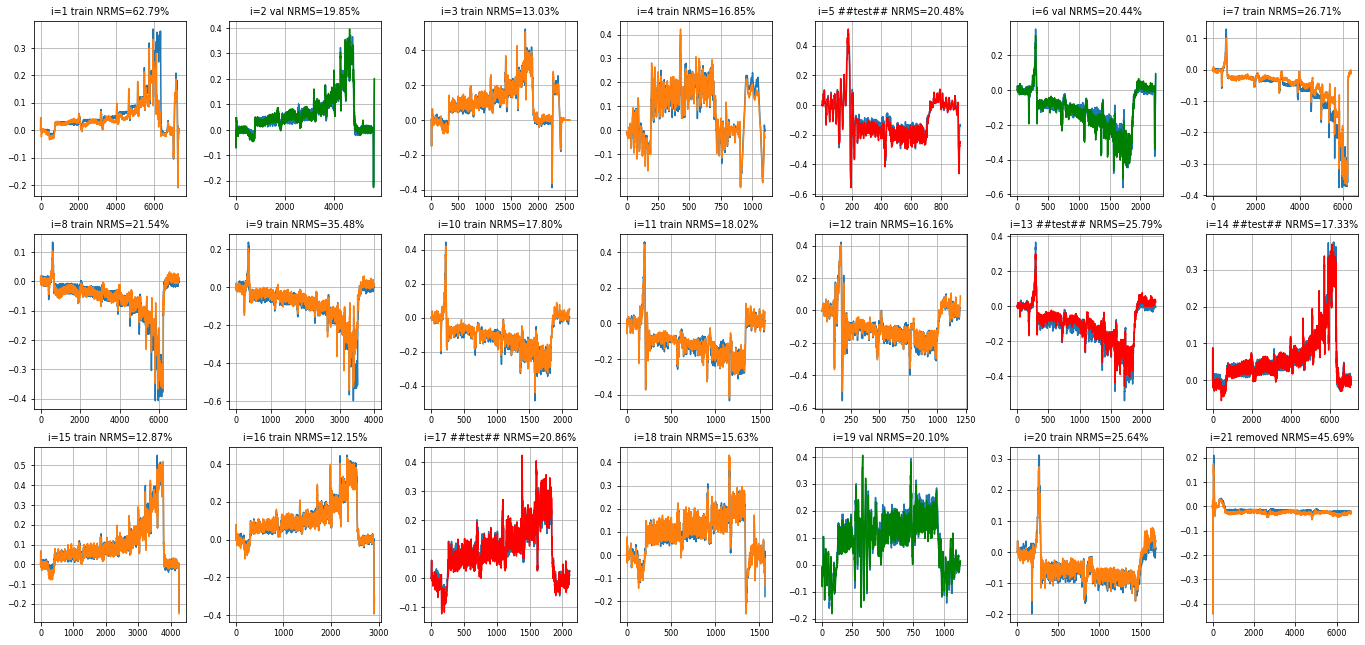

######## Residual  #########


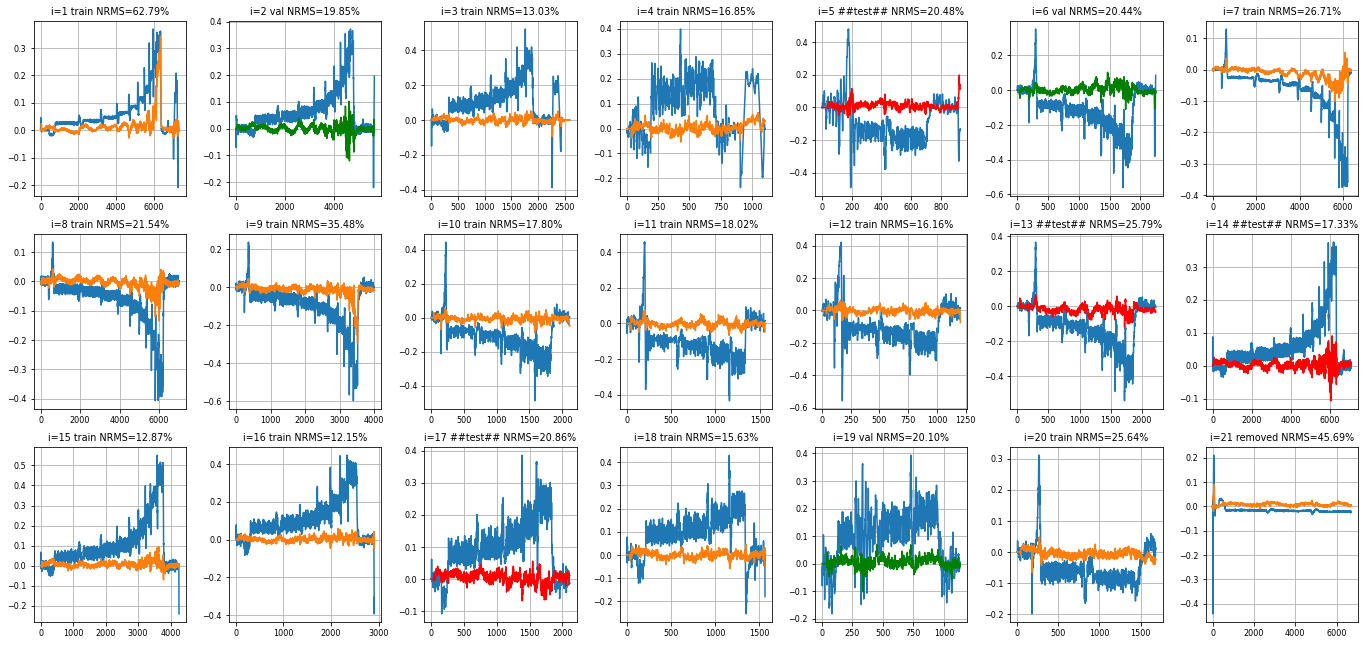

Saving individual figures...


In [8]:
def get_plots(full,full_sim,residual=True,subfigures=False,save=False):
    if subfigures:
        plt.figure(figsize=(19,9))
        plt.rcParams.update({'font.size': 8})
    else:
        plt.rcParams.update({'font.size': 14})
    for i in range(len(full_sim)):
        
        if subfigures:
            plt.subplot(3,7,i+1)
            plt.grid()
            plt.title(f'i={i+1} {get_string(i)} NRMS={full_sim[i].NRMS(full[i]):.2%}')
        plt.plot(full[i].y)
        yplot = full_sim[i].y if residual==False else full[i].y-full_sim[i].y
        if (i in test_ids):
            plt.plot(yplot,'r')
        elif (i in val_ids):
            plt.plot(yplot,'g')
        else:
            plt.plot(yplot)
        if not subfigures:
            plt.legend(['Measured','Encoder simulation'])
            plt.xlabel('time index')
            plt.ylabel('yaw rate')
            plt.tight_layout()
            if save:
                k = 'res' if residual else 'abs'
                name = 'test' if (i in test_ids) else ('val' if (i in val_ids) else ('train' if (i in train_ids) else 'removed'))
                plt.savefig(f'./Figures/encoder-sim-{i+1}-{name}-{k}.pdf')
                plt.close()
            else:
                plt.title(f'data set id = {i+1}')
                plt.show()
    if subfigures:
        plt.tight_layout()
        if save:
            k = 'res' if residual else 'abs'
            plt.savefig(f'./Figures/encoder-sim-subfigures-{k}.pdf')
        plt.show()  

print('######## Overlayed #########')
get_plots(full,full_sim,residual=False,subfigures=True,save=True)
print('######## Residual  #########')
get_plots(full,full_sim,residual=True,subfigures=True,save=True)
print('Saving individual figures...')
get_plots(full,full_sim,residual=False,subfigures=False,save=True)
get_plots(full,full_sim,residual=True,subfigures=False,save=True)

## n-step NRMS error


$$
    \text{NRMS}_n = \frac{\sqrt{1/M \sum_{i=1}^{M} (\hat{y}_{t_i \xrightarrow{} t_i + n} - y_{t_i + n})^2} }{\sigma_y}.
$$

There is a significant amount of overfitting on the training data.

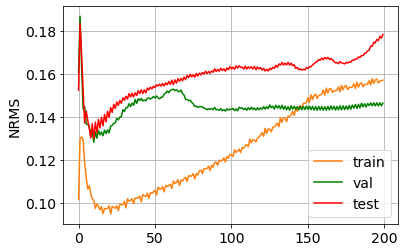

In [9]:
def n_step_error_plots(sys,train,test,val,nf=100):
    plt.plot(sys.n_step_error(train,dilation=5,nf=nf),'tab:orange',label='train')
    plt.plot(sys.n_step_error(val,dilation=1,nf=nf),'g',label='val')
    plt.plot(sys.n_step_error(test,dilation=1,nf=nf),'r',label='test')
    plt.grid()
    plt.ylabel('NRMS')
    plt.legend()
    plt.show()
n_step_error_plots(sys_encoder,train,test,val,nf=200)